In [1]:
import networkx as nx
import numpy as np

import seaborn as sns

from matplotlib import pyplot as plt

import pickle as pkl

%load_ext autoreload
%autoreload 2

SEED = 181731

In [50]:
def plotRegrets(allRegrets, titles=None, save_fig=None,legend = True):
    """
    param allRegrets: list of dictionaries of regrets(samples, time_steps) for various algorithms and runs
    """
    nPlots = len(allRegrets)
    
    plt.style.use('seaborn-whitegrid')
    # sns.set()
    
    labels = {'greedy': 'Local $\epsilon$-greedy', 'thompson': 'Local TS', 'UCB': 'Local UCB','Q_learning': 'Q-learning',\
              'Our Algorithm':'Our Algorithm'}
    styles = {'greedy': 'dashed', 'thompson': 'dashed', 'UCB': 'dashed','Q_learning': 'dotted',\
              'Our Algorithm':'solid'}
    colors = {'greedy': 'b', 'thompson': 'y', 'UCB': 'mediumseagreen','Q_learning': 'grey',\
              'Our Algorithm':'b'}
    keys = allRegrets[0].keys()
    

    if nPlots == 1:
        regrets = allRegrets[0]
        for i, key in enumerate(keys):
            regret = regrets[key]
            regret = np.cumsum(regret, axis=1)
            regret = np.mean(regret, axis=0)
            plt.plot([i for i in range(1,len(regret)+1)],regret, c=colors[key], linestyle = styles[key], label=labels[key],\
                    linewidth=5)
        if titles is not None:    
            plt.title(titles[0])
    # else:
    #     fig, axes = plt.subplots(2, 3, figsize=(17,10))
    #     for j, regrets in enumerate(allRegrets):
    #         for i, key in enumerate(regrets.keys()):
    #             regret = regrets[key]
    #             regret = np.cumsum(regret, axis=1)
    #             df = pd.DataFrame(np.transpose(regret))
    #             df.columns = [labels[key] for _ in range(regret.shape[0])]
    #             if j<3:
    #                 sns.lineplot(ax = axes[0,j], data=df, ci=None, palette=[colors[key]])
    #                 axes[0,j].set_title(titles[j])
    #             else:
    #                 sns.lineplot(ax = axes[1,j%3], data=df, ci=None, palette=[colors[key]])
    #                 axes[1,j%3].set_title(titles[j])
    if legend:
        plt.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.45), fontsize=16)
        
    plt.xlabel('$t$', fontsize=25)
    plt.ylabel('Regret', fontsize=25)
    plt.tick_params(labelsize=25)
    if save_fig is not None:
        plt.savefig('Figures/'+save_fig, bbox_inches = 'tight')
    plt.show()

In [23]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

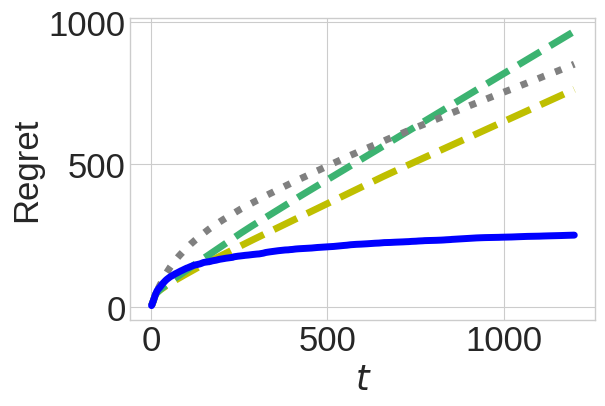

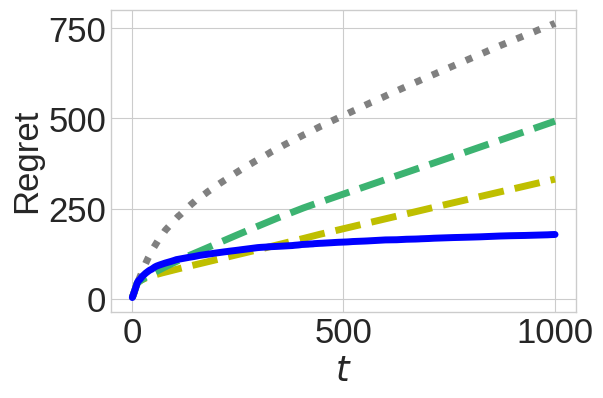

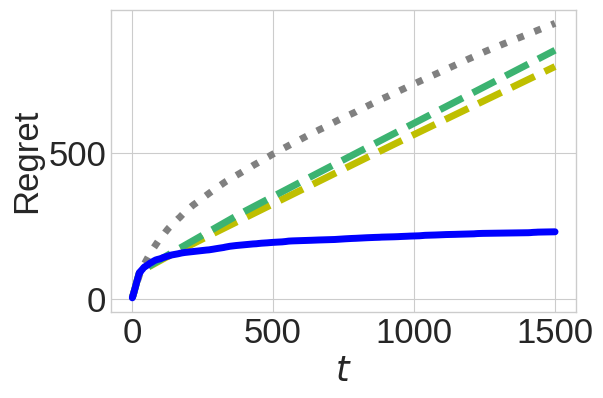

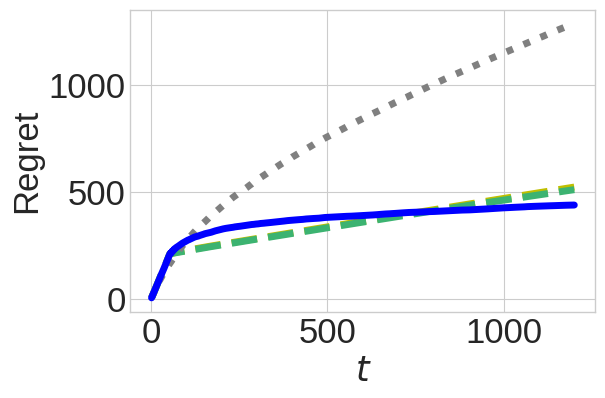

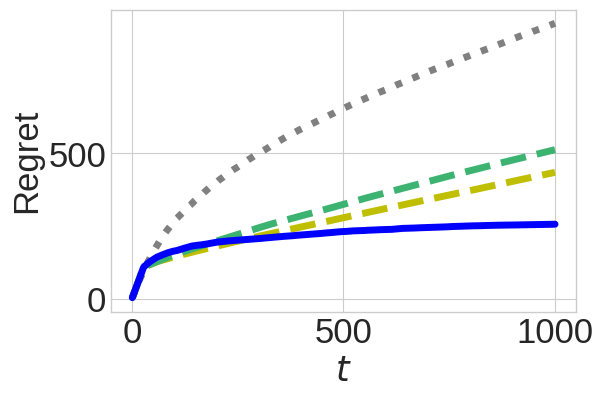

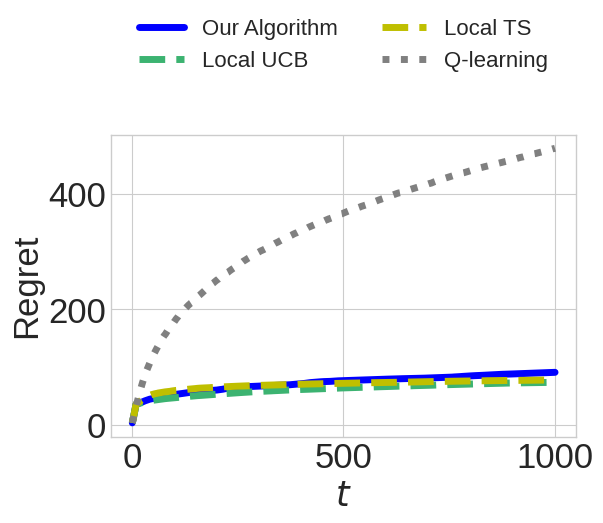

In [51]:
graphs = ['line','circle','tree', 'star', 'grid','fully-connected']
legend = {g:False for g in graphs}
legend['fully-connected']= True

for g in graphs:
    
    # try:
    with open('Data/1tQL/{}.pkl'.format(g), 'rb') as file:
        data = pkl.load(file)

    plt.figure(dpi=100)
    plotRegrets([data], [''],'1tQL/{}.png'.format(g),legend=legend[g])
    # except:
    #     pass